# Quality Assurance with RasCheck

This notebook demonstrates how to use the RasCheck module for validating HEC-RAS steady flow models using **multiple example projects** to show different validation scenarios.

In [21]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfResultsPlan, RasCmdr, RasExamples, RasPlan, RasPrj, init_ras_project, ras

# Verify which version loaded
import ras_commander
print(f"Loaded: {ras_commander.__file__}")

PIP PACKAGE MODE: Loading installed ras-commander
Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your projects. This notebook uses **multiple projects** to demonstrate different RasCheck validation scenarios.

In [22]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# HEC-RAS Version
RAS_VERSION = "6.6"
SUFFIX = "800"  # Suffix for project extraction

# =============================================================================
# PROJECT SELECTION FOR RASCHECK DEMONSTRATION
# =============================================================================
# RasCheck validates STEADY FLOW models (requires multiple steady profiles).
#
# VERIFIED PROJECTS (tested and confirmed steady):
# - Balde Eagle Creek, Plan 02: 8 steady profiles, structures, good spacing variation
#
# TO ADD MORE PROJECTS:
# 1. Extract project: RasExamples.extract_project("ProjectName")
# 2. Initialize: init_ras_project(path, "6.6", ras_object=test_ras)
# 3. Check plans: test_ras.plan_df[['plan_number', 'Plan Title', 'flow_type']]
# 4. Verify steady: HdfResultsPlan.is_steady_plan(plan_num, ras_object=test_ras)
# 5. Count profiles: len(HdfResultsPlan.get_steady_profile_names(plan_num, ras_object=test_ras))
# 6. Add to PROJECTS list below if steady with 2+ profiles

PROJECTS = [
    {
        "name": "Balde Eagle Creek",
        "plan": "02",  # VERIFIED: Steady Flow Run with 8 profiles (0.5yr - 100yr)
        "description": "1D river model with bridges/dam, 8 steady profiles for profile consistency checks",
        "check_focus": ["NT (Manning's n)", "XS (spacing)", "Structures (bridge/dam)", "Profiles (consistency)"],
        "expected_messages": "Moderate - expect spacing warnings, structure coefficient checks"
    },
    # TODO: Add more steady-flow projects here following verification steps above
    # Example template:
    # {
    #     "name": "YourProjectName",
    #     "plan": "##",  # Plan number verified as steady
    #     "description": "Description with number of profiles",
    #     "check_focus": ["NT", "XS", "Structures", "Profiles"],
    #     "expected_messages": "Brief description of expected validation results"
    # },
]

# Execution Settings
NUM_CORES = 2  # Cores per project (conservative for multi-project execution)

# Display configuration
print(f"Configured {len(PROJECTS)} project(s) for RasCheck validation:")
for p in PROJECTS:
    print(f"\n  {p['name']} (Plan {p['plan']}):")
    print(f"    - {p['description']}")
    print(f"    - Focus Areas: {', '.join(p['check_focus'])}")
    print(f"    - Expected: {p['expected_messages']}")

print(f"\nTo add more projects, see verification instructions in PARAMETERS cell comments.")

Configured 1 project(s) for RasCheck validation:

  Balde Eagle Creek (Plan 02):
    - 1D river model with bridges/dam, 8 steady profiles for profile consistency checks
    - Focus Areas: NT (Manning's n), XS (spacing), Structures (bridge/dam), Profiles (consistency)
    - Expected: Moderate - expect spacing warnings, structure coefficient checks

To add more projects, see verification instructions in PARAMETERS cell comments.


---

## Attribution

> **Based on FEMA cHECk-RAS**
>
> This module implements the validation checks described in FEMA's
> [cHECk-RAS](https://www.fema.gov/flood-maps/tutorials/check-ras) quality assurance tool
> for HEC-RAS 6.x models, using ras-commander's HDF function library.
>
> From FEMA's cHECk-RAS page:
>
> *"cHECk-RAS utilizes information generated by HEC-RAS (all versions through the latest
> version, 5.0.7). Note, cHECk-RAS is not compatible with the two-dimensional component
> of HEC-RAS 5.0.7."*
>
> This Python implementation extends these validation checks to work with modern HEC-RAS 6.x
> HDF-based outputs, providing equivalent functionality through the ras-commander library.

> **For Informational Purposes Only**
>
> Outputs from this library are still in Beta and are provided for **informational purposes only**.  These guidelines provide a flexible framework based on commonly accepted industry standards for users to build their own validation checks and QAQC workflows.  > judgment.

**NOTE**: This is an UNOFFICIAL Python implementation and is NOT affiliated with or endorsed by FEMA.

## Overview

The **RasCheck** module provides comprehensive quality assurance validation for HEC-RAS steady flow models. It implements the validation checks described in FEMA's cHECk-RAS using modern HDF-based data access for HEC-RAS 6.x models.

### Check Categories

| Check | Description | Key Validations |
|-------|-------------|------------------|
| **NT Check** | Manning's n and Transition | Roughness coefficients, contraction/expansion losses |
| **XS Check** | Cross Section Validation | Spacing, ineffective flow, reach lengths, levees |
| **Structure Check** | Bridges, Culverts, Weirs | Flow classification, coefficients, geometry |
| **Floodway Check** | Floodway Analysis | Surcharge limits, encroachment methods |
| **Profiles Check** | Multiple Profile Consistency | WSE ordering, discharge consistency |

### LLM Forward Verification Approach

This notebook follows **LLM Forward** principles for quality assurance:

1. **Visual Verification**: Every validation check produces reviewable outputs via notbook outputs
2. **Multiple Review Pathways**: 
   - Traditional engineering review (HTML reports with message IDs)
   - Visual inspection (DataFrame filtering and grouping)
   - Code audit trail (@log_call decorators track all validation operations)
3. **Agentic Scaffolding** - Intended to serve as a framework for building your own agentic QAQC workflows using ras-commander
4. **Professional Responsibility**: These checks support, but do not replace, professional engineering judgment


## Import Required Modules

**Note**: The RasCheck module is currently in development. Ensure `USE_LOCAL_SOURCE = True` in the toggle cell above to load the local development version.

For detailed demonstrations of the new validation features, see:
- **801_advanced_structure_validation.ipynb** - Culvert and starting WSE validation
- **802_custom_workflows_and_standards.ipynb** - State-specific standards and custom workflows

In [23]:
from ras_commander import (
    RasExamples, RasPlan, RasPrj, init_ras_project, ras,
    RasCmdr, HdfResultsPlan
)
from ras_commander.check import (
    RasCheck, CheckResults, Severity,
    RasCheckReport, ReportMetadata,
    get_default_thresholds, create_custom_thresholds,
    get_state_surcharge_limit
)

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Set pandas display options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Extract and Initialize Multiple Projects

We'll extract multiple example projects to demonstrate different RasCheck validation scenarios. Each project has different characteristics:

1. **Bald Eagle Creek**: 1D river model with bridges/dam and 8 steady flow profiles (0.5yr - 100yr)
2. **Single Culvert**: Applications Guide example with culvert structure
3. **Floodway Determination**: Floodway analysis with encroachment

This multi-project approach demonstrates how RasCheck handles different model types and validation scenarios.

In [24]:
# Extract all configured projects
project_paths = {}
project_ras_objects = {}

for proj_config in PROJECTS:
    name = proj_config["name"]
    print(f"\nExtracting: {name}...")
    
    try:
        path = RasExamples.extract_project(name, suffix=SUFFIX)
        project_paths[name] = path
        
        # Initialize with separate RasPrj object (multi-project pattern)
        ras_obj = RasPrj()
        init_ras_project(path, RAS_VERSION, ras_object=ras_obj)
        project_ras_objects[name] = ras_obj
        
        print(f"  Initialized: {ras_obj.project_name}")
        print(f"  Plans: {len(ras_obj.plan_df)}")
        
    except Exception as e:
        print(f"  Failed: {e}")
        project_paths[name] = None
        project_ras_objects[name] = None

print(f"\nSuccessfully initialized {len([p for p in project_paths.values() if p])} of {len(PROJECTS)} projects")

2026-01-14 19:35:29 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-14 19:35:29 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek' as 'Balde Eagle Creek_800'
2026-01-14 19:35:29 - ras_commander.RasExamples - INFO - Folder 'Balde Eagle Creek_800' already exists. Deleting existing folder...
2026-01-14 19:35:29 - ras_commander.RasExamples - INFO - Existing folder 'Balde Eagle Creek_800' has been deleted.
2026-01-14 19:35:29 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800
2026-01-14 19:35:29 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.rasmap
2026-01-14 19:35:29 - ras_commander.RasPrj - INFO - Updated results_df with 2 plan


Extracting: Balde Eagle Creek...
  Initialized: BaldEagle
  Plans: 2

Successfully initialized 1 of 1 projects


In [25]:
# Display available plans for each project
for name, ras_obj in project_ras_objects.items():
    if ras_obj is None:
        continue
    print(f"\n{name} - Available Plans:")
    print("-" * 60)
    display(ras_obj.plan_df[['plan_number', 'Plan Title', 'flow_type']].head(5))


Balde Eagle Creek - Available Plans:
------------------------------------------------------------


,plan_number,Plan Title,flow_type
0,01,Unsteady with Bridges and Dam,Unsteady
1,02,Steady Flow Run,Steady


## Run Steady Flow Plans

RasCheck requires computed results in the HDF file. We'll run the steady flow plans for each project.

In [26]:
# Execute steady flow plans for each project
execution_results = {}

for proj_config in PROJECTS:  # Using verified projects only
    name = proj_config["name"]
    plan = proj_config["plan"]
    ras_obj = project_ras_objects.get(name)

    if ras_obj is None:
        print(f"Skipping {name}: not initialized")
        continue

    print(f"\nRunning {name} Plan {plan}...")

    try:
        # Check if already computed
        hdf_path = RasPlan.get_results_path(plan, ras_object=ras_obj)

        if hdf_path and Path(hdf_path).exists():
            print(f"  Results already exist: {Path(hdf_path).name}")
            execution_results[name] = True
            
            # Verify it's still steady and get profile count
            is_steady = HdfResultsPlan.is_steady_plan(plan, ras_object=ras_obj)
            if is_steady:
                profiles = HdfResultsPlan.get_steady_profile_names(plan, ras_object=ras_obj)
                print(f"  Steady plan with {len(profiles)} profiles (already computed)")
        else:
            # Need to compute
            success = RasCmdr.compute_plan(
                plan_number=plan,
                ras_object=ras_obj,
                num_cores=NUM_CORES
            )
            execution_results[name] = success

            if success:
                # Verify it's a steady plan and get profile names
                is_steady = HdfResultsPlan.is_steady_plan(plan, ras_object=ras_obj)
                if is_steady:
                    profiles = HdfResultsPlan.get_steady_profile_names(plan, ras_object=ras_obj)
                    print(f"  Steady plan with {len(profiles)} profiles")
                else:
                    print(f"  Plan executed but is UNSTEADY - this should not happen!")
            else:
                print(f"  Execution failed")

    except Exception as e:
        print(f"  Error: {e}")
        execution_results[name] = False

print(f"\n{'='*60}")
print(f"Execution Summary:")
print(f"{'='*60}")
for name, success in execution_results.items():
    status = "[OK] Success" if success else "[ERROR] Failed"
    print(f"  {name}: {status}")

2026-01-14 19:35:29 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800
2026-01-14 19:35:29 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02
2026-01-14 19:35:29 - ras_commander.RasUtils - INFO - Successfully updated file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02
2026-01-14 19:35:29 - ras_commander.RasCmdr - INFO - Set number of cores to 2 for plan: 02
2026-01-14 19:35:29 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2026-01-14 19:35:29 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-pa


Running Balde Eagle Creek Plan 02...


2026-01-14 19:35:36 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 02
2026-01-14 19:35:36 - ras_commander.RasCmdr - INFO - Total run time for plan 02: 6.39 seconds
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02.hdf
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02.hdf
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p02.hdf
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 718 characters from HDF
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\

  Steady plan with 8 profiles

Execution Summary:
  Balde Eagle Creek: [OK] Success


In [27]:
# Display results summary from results_df
ras_obj.results_df[['plan_number', 'plan_title', 'completed', 'has_errors', 'has_warnings', 'runtime_complete_process_hours']]

,plan_number,plan_title,completed,has_errors,has_warnings,runtime_complete_process_hours
0,01,Unsteady with Bridges and Dam,False,False,False,None
1,02,Steady Flow Run,True,False,False,None


---

## Running RasCheck Validation on Multiple Projects

Now we'll run RasCheck validation on each project and compare the results. This demonstrates how different model types produce different validation messages.

In [28]:
# Run RasCheck on all projects
all_results = {}

for proj_config in PROJECTS:
    name = proj_config["name"]
    plan = proj_config["plan"]
    ras_obj = project_ras_objects.get(name)
    
    if ras_obj is None or not execution_results.get(name, False):
        print(f"Skipping {name}: not ready for validation")
        continue
    
    print(f"\nValidating {name} Plan {plan}...")
    
    try:
        results = RasCheck.run_all(plan, ras_object=ras_obj)
        all_results[name] = results
        
        print(f"  Total Messages: {len(results.messages)}")
        print(f"  Errors: {results.get_error_count()}")
        print(f"  Warnings: {results.get_warning_count()}")
        print(f"  Info: {len(results.messages) - results.get_error_count() - results.get_warning_count()}")
        
    except Exception as e:
        print(f"  Validation Error: {e}")
        all_results[name] = None

2026-01-14 19:35:36 - ras_commander.check.RasCheck - INFO - Detected flow type: steady
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02.hdf
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02.hdf
2026-01-14 19:35:36 - ras_commander.hdf.HdfResultsPlan - INFO - Extracted steady results: 1424 rows (8 profiles x 178 cross sections)



Validating Balde Eagle Creek Plan 02...


2026-01-14 19:35:37 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.g01.hdf
2026-01-14 19:35:37 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.g01.hdf
2026-01-14 19:35:37 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.g01.hdf
2026-01-14 19:35:37 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.g01.hdf
2026-01-14 19:35:37 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF fi

  Total Messages: 5782
  Errors: 0
  Warnings: 4714
  Info: 1068


### Compare Validation Results Across Projects

Let's create a summary comparison of validation results across all projects.

In [29]:
# Create comparison summary
comparison_data = []

for name, results in all_results.items():
    if results is None:
        continue
    
    df = results.to_dataframe()
    
    # Get check type breakdown
    check_types = df['check_type'].value_counts().to_dict() if not df.empty else {}
    
    comparison_data.append({
        'Project': name,
        'Total Messages': len(results.messages),
        'Errors': results.get_error_count(),
        'Warnings': results.get_warning_count(),
        'Info': len(results.messages) - results.get_error_count() - results.get_warning_count(),
        'Check Types': ', '.join(check_types.keys())
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("Validation Results Comparison:")
    print("=" * 80)
    display(comparison_df)
else:
    print("No validation results to compare")

Validation Results Comparison:


,Project,Total Messages,Errors,Warnings,Info,Check Types
0,Balde Eagle Creek,5782,0,4714,1068,"PROFILES, XS, NT, STRUCT"


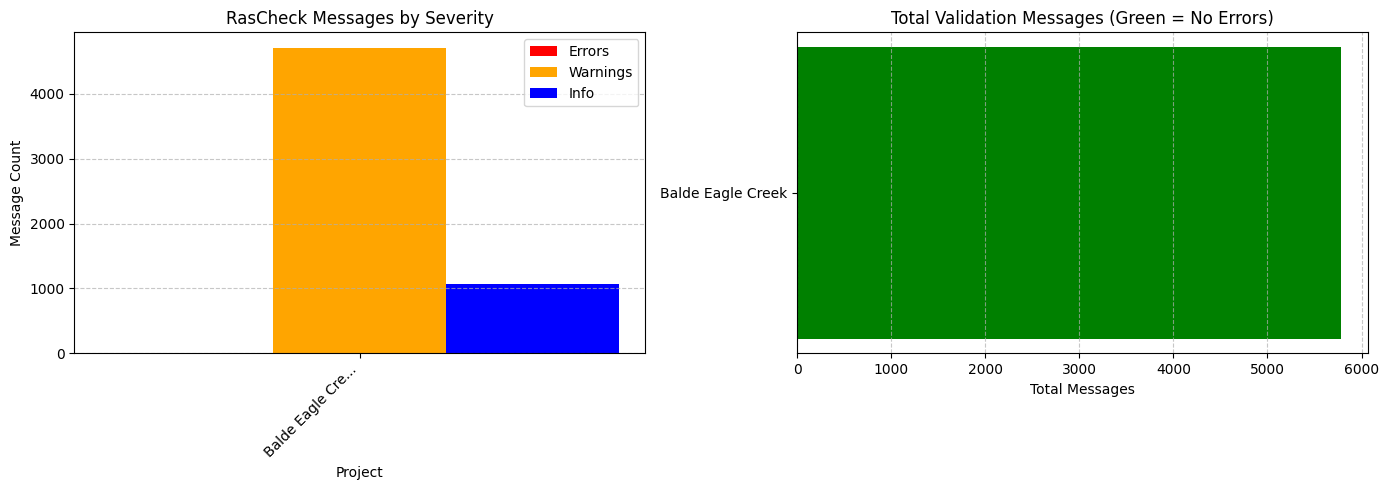

In [30]:
# Visualize comparison
if comparison_data:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart of message counts by project
    ax1 = axes[0]
    x = range(len(comparison_df))
    width = 0.25
    
    ax1.bar([i - width for i in x], comparison_df['Errors'], width, label='Errors', color='red')
    ax1.bar([i for i in x], comparison_df['Warnings'], width, label='Warnings', color='orange')
    ax1.bar([i + width for i in x], comparison_df['Info'], width, label='Info', color='blue')
    
    ax1.set_xlabel('Project')
    ax1.set_ylabel('Message Count')
    ax1.set_title('RasCheck Messages by Severity')
    ax1.set_xticks(x)
    ax1.set_xticklabels([p[:15] + '...' if len(p) > 15 else p for p in comparison_df['Project']], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Total messages comparison
    ax2 = axes[1]
    colors = ['green' if e == 0 else 'red' for e in comparison_df['Errors']]
    ax2.barh(comparison_df['Project'], comparison_df['Total Messages'], color=colors)
    ax2.set_xlabel('Total Messages')
    ax2.set_title('Total Validation Messages (Green = No Errors)')
    ax2.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

---

## Detailed Analysis: First Project

Let's perform a detailed analysis on the first project to demonstrate the full RasCheck workflow.

In [41]:
# Select the first project for detailed analysis
first_project_name = list(all_results.keys())[0] if all_results else None
first_results = all_results.get(first_project_name) if first_project_name else None

if first_results:
    print(f"Detailed Analysis: {first_project_name}")
    print("=" * 60)
    
    # Convert to DataFrame
    df = first_results.to_dataframe()
    # Ensure full message column is visible
    import pandas as pd
    pd.set_option('display.max_colwidth', None)
    print(f"\nDataFrame shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    display(df.head(10))
else:
    print("No results available for detailed analysis")

Detailed Analysis: Balde Eagle Creek

DataFrame shape: (5782, 12)
Columns: ['message_id', 'severity', 'check_type', 'river', 'reach', 'station', 'structure', 'message', 'flagged', 'comment', 'value', 'threshold']


,message_id,severity,check_type,river,reach,station,structure,message,flagged,comment,value,threshold
0,NT_RC_01L,WARNING,NT,Bald Eagle,Loc Hav,49715.77,,Left overbank Manning's n value (0.012) is less than 0.030,False,,0.012000,0.03
1,NT_RC_05,INFO,NT,Bald Eagle,Loc Hav,49715.77,,"Overbank n values (LOB=0.012, ROB=0.130) are not greater than channel n (0.040)",False,,NaN,None
2,NT_RC_03C,WARNING,NT,Bald Eagle,Loc Hav,24843.25,,Channel Manning's n value (0.005) is less than 0.025,False,,0.005000,0.025
3,NT_VR_01R,WARNING,NT,Bald Eagle,Loc Hav,70651.52,,Large ROB n-value change (118%) between RS 71400.81 (0.055) and RS 70651.52 (0.120),False,,118.181814,None
4,NT_VR_01L,WARNING,NT,Bald Eagle,Loc Hav,68604.09,,Large LOB n-value change (100%) between RS 6940.066 (0.050) and RS 68604.09 (0.100),False,,100.000000,None
5,NT_VR_01L,WARNING,NT,Bald Eagle,Loc Hav,64908.02,,Large LOB n-value change (60%) between RS 659.942 (0.075) and RS 64908.02 (0.120),False,,59.999990,None
6,NT_VR_01L,WARNING,NT,Bald Eagle,Loc Hav,6267.489,,Large LOB n-value change (58%) between RS 62746.41 (0.120) and RS 6267.489 (0.050),False,,58.333332,None
7,NT_VR_01L,WARNING,NT,Bald Eagle,Loc Hav,61896.89,,Large LOB n-value change (140%) between RS 6267.489 (0.050) and RS 61896.89 (0.120),False,,139.999991,None
8,NT_VR_01L,WARNING,NT,Bald Eagle,Loc Hav,5523.234,,Large LOB n-value change (64%) between RS 55700.55 (0.140) and RS 5523.234 (0.050),False,,64.285714,None
9,NT_VR_01L,WARNING,NT,Bald Eagle,Loc Hav,54696.51,,Large LOB n-value change (180%) between RS 5523.234 (0.050) and RS 54696.51 (0.140),False,,179.999997,None


In [32]:
# Group messages by check type and severity
if first_results and not df.empty:
    check_summary = df.groupby(['check_type', 'severity']).size().unstack(fill_value=0)
    print("Messages by Check Type and Severity:")
    display(check_summary)

Messages by Check Type and Severity:


severity,INFO,WARNING
check_type,,
NT,1,44
PROFILES,473,3671
STRUCT,1,33
XS,593,966


In [33]:
# Show ERROR messages (if any)
if first_results:
    errors = first_results.filter_by_severity(Severity.ERROR)
    print(f"\nERROR Messages ({len(errors)} total):")
    print("-" * 60)
    
    for msg in errors[:10]:  # Show first 10
        print(f"  [{msg.message_id}] {msg.check_type}")
        print(f"    {msg.message}")
        print()


ERROR Messages (0 total):
------------------------------------------------------------


In [34]:
# Show WARNING messages (sample)
if first_results:
    warnings = first_results.filter_by_severity(Severity.WARNING)
    print(f"\nWARNING Messages ({len(warnings)} total, showing first 5):")
    print("-" * 60)
    
    for msg in warnings[:5]:
        print(f"  [{msg.message_id}] RS {msg.station}: {msg.message[:80]}...")


WARNING Messages (4714 total, showing first 5):
------------------------------------------------------------
  [NT_RC_01L] RS 49715.77: Left overbank Manning's n value (0.012) is less than 0.030...
  [NT_RC_03C] RS 24843.25: Channel Manning's n value (0.005) is less than 0.025...
  [NT_VR_01R] RS 70651.52: Large ROB n-value change (118%) between RS 71400.81 (0.055) and RS 70651.52 (0.1...
  [NT_VR_01L] RS 68604.09: Large LOB n-value change (100%) between RS 6940.066 (0.050) and RS 68604.09 (0.1...
  [NT_VR_01L] RS 64908.02: Large LOB n-value change (60%) between RS 659.942 (0.075) and RS 64908.02 (0.120...


### Message ID Distribution

RasCheck uses standardized message IDs to categorize issues:

```
{CHECK_TYPE}_{CATEGORY}_{NUMBER}{SUFFIX}
```

Examples:
- `NT_RC_01L` - NT Check, Roughness Coefficient, Message 01, Left side
- `XS_DT_02R` - XS Check, Distance/Travel, Message 02, Right side
- `BR_TF_04` - Bridge, Type Flow, Message 04
- `MP_WS_01` - Multiple Profile, Water Surface, Message 01

In [35]:
# Analyze message ID distribution
if first_results and not df.empty:
    print("Message ID Distribution:")
    print("=" * 50)
    msg_counts = df['message_id'].value_counts()
    display(msg_counts.head(15))

Message ID Distribution:


message_id
MP_Q_01        1246
MP_WS_01       1246
PF_VEL_01       895
MP_TW_01        473
XS_AR_01        360
PF_TW_01        284
XS_EC_01L       181
XS_SL_01        181
XS_GD_01        178
XS_EC_01R       155
XS_TW_02        148
XS_FS_01        135
XS_SL_02        132
XS_EC_01BUL      14
XS_EC_01BDL      14
Name: count, dtype: int64

---

## Generating Reports for All Projects

Generate HTML and CSV reports for each validated project.

In [36]:
# Generate reports for all projects
report_paths = {}

for name, results in all_results.items():
    if results is None:
        continue
    
    project_path = project_paths[name]
    ras_obj = project_ras_objects[name]
    
    # Create report folder
    report_folder = project_path / "ras_checker"
    report_folder.mkdir(parents=True, exist_ok=True)
    
    # Create metadata
    metadata = ReportMetadata(
        project_name=ras_obj.project_name,
        project_path=project_path,
        plan_name=f"Plan {[p['plan'] for p in PROJECTS if p['name'] == name][0]}"
    )
    
    # Generate HTML report
    html_path = report_folder / "validation_report.html"
    results.to_html(html_path, metadata=metadata)
    
    # Export CSV
    csv_path = report_folder / "validation_messages.csv"
    df = results.to_dataframe()
    if not df.empty:
        df.to_csv(csv_path, index=False)
    
    report_paths[name] = {
        'html': html_path,
        'csv': csv_path
    }
    
    print(f"Reports generated for {name}:")
    print(f"  HTML: {html_path}")
    print(f"  CSV: {csv_path}")

2026-01-14 19:35:38 - ras_commander.check.report - INFO - Generated HTML report: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\ras_checker\validation_report.html


Reports generated for Balde Eagle Creek:
  HTML: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\ras_checker\validation_report.html
  CSV: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\ras_checker\validation_messages.csv


---

## Customizing Validation Thresholds

RasCheck uses configurable thresholds for all checks. You can customize these for project-specific requirements.

In [37]:
# View default thresholds
defaults = get_default_thresholds()

print("Default Manning's n Thresholds:")
print(f"  Overbank: {defaults.mannings_n.overbank_min} - {defaults.mannings_n.overbank_max}")
print(f"  Channel:  {defaults.mannings_n.channel_min} - {defaults.mannings_n.channel_max}")

print("\nDefault Transition Coefficients:")
print(f"  Structures: Contraction={defaults.transitions.structure_contraction_max}, Expansion={defaults.transitions.structure_expansion_max}")
print(f"  Regular XS: Contraction={defaults.transitions.regular_contraction_max}, Expansion={defaults.transitions.regular_expansion_max}")

Default Manning's n Thresholds:
  Overbank: 0.03 - 0.2
  Channel:  0.025 - 0.1

Default Transition Coefficients:
  Structures: Contraction=0.3, Expansion=0.5
  Regular XS: Contraction=0.1, Expansion=0.3


In [38]:
# Create custom thresholds for stricter validation
custom_thresholds = create_custom_thresholds({
    # Stricter Manning's n limits
    'mannings_n.overbank_min': 0.035,
    'mannings_n.overbank_max': 0.150,
    'mannings_n.channel_min': 0.028,
    'mannings_n.channel_max': 0.080,
    
    # Custom reach length limits
    'reach_length.max_length_ft': 2000.0,
    'reach_length.length_ratio_max': 1.5,
})

print("Custom thresholds created")
print(f"  Custom overbank min: {custom_thresholds.mannings_n.overbank_min}")
print(f"  Custom overbank max: {custom_thresholds.mannings_n.overbank_max}")

Custom thresholds created
  Custom overbank min: 0.035
  Custom overbank max: 0.15


In [39]:
# Compare default vs custom thresholds on first project
if first_project_name and project_ras_objects.get(first_project_name):
    ras_obj = project_ras_objects[first_project_name]
    plan = [p['plan'] for p in PROJECTS if p['name'] == first_project_name][0]
    
    # Run with custom thresholds
    custom_results = RasCheck.run_all(plan, ras_object=ras_obj, thresholds=custom_thresholds)
    
    print(f"Threshold Comparison for {first_project_name}:")
    print(f"  Default thresholds: {len(first_results.messages)} messages")
    print(f"  Custom thresholds:  {len(custom_results.messages)} messages")
    print(f"  Difference: {len(custom_results.messages) - len(first_results.messages):+d} messages")

2026-01-14 19:35:38 - ras_commander.check.RasCheck - INFO - Detected flow type: steady
2026-01-14 19:35:38 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02.hdf
2026-01-14 19:35:38 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.p02.hdf
2026-01-14 19:35:38 - ras_commander.hdf.HdfResultsPlan - INFO - Extracted steady results: 1424 rows (8 profiles x 178 cross sections)
2026-01-14 19:35:39 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_800\BaldEagle.g01.hdf
2026-01-14 19:35:39 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\Us

Threshold Comparison for Balde Eagle Creek:
  Default thresholds: 5782 messages
  Custom thresholds:  5792 messages
  Difference: +10 messages


---

## State-Specific Floodway Surcharge Limits

Different states have different maximum surcharge limits for floodway analysis. This is important when validating floodway models for regulatory submittals.

In [40]:
# View state-specific surcharge limits
print("State-Specific Surcharge Limits:")
print("=" * 40)

states = ['TX', 'IL', 'WI', 'MN', 'NJ', 'MI', 'IN', 'OH', 'PA', 'NY']
surcharge_data = []

for state in states:
    limit = get_state_surcharge_limit(state)
    surcharge_data.append({'State': state, 'Surcharge Limit (ft)': limit})
    print(f"  {state}: {limit:.2f} ft")

# Create DataFrame for reference
surcharge_df = pd.DataFrame(surcharge_data)
print("\nNote: Default limit is 1.0 ft. States with stricter limits require special attention.")

State-Specific Surcharge Limits:
  TX: 1.00 ft
  IL: 0.10 ft
  WI: 0.01 ft
  MN: 0.50 ft
  NJ: 0.20 ft
  MI: 1.00 ft
  IN: 1.00 ft
  OH: 1.00 ft
  PA: 1.00 ft
  NY: 1.00 ft

Note: Default FEMA limit is 1.0 ft. States with stricter limits require special attention.


---

## Summary

This notebook demonstrated multi-project RasCheck validation following LLM Forward principles:

### What You Learned

1. **Multi-Project Validation**:
   - Extract and initialize multiple HEC-RAS projects
   - Run RasCheck validation across different model types
   - Compare validation results between projects

2. **Running Validation Checks**:
   - `RasCheck.run_all()` for comprehensive validation
   - Individual check methods for targeted QA
   - Custom thresholds for project-specific requirements

3. **Analyzing Results**:
   - Filter by severity (ERROR, WARNING, INFO)
   - Group by check type (NT, XS, Structure, etc.)
   - Filter by station for site-specific issues
   - Compare results across multiple projects

4. **Generating Audit Trail**:
   - HTML reports for submittal packages
   - CSV exports for issue tracking
   - Metadata documentation for project context

### Key Classes and Methods

| Class/Method | Description | When to Use |
|--------------|-------------|-------------|
| `RasCheck.run_all()` | Run all validation checks | Final QA before submittal |
| `RasCheck.check_nt()` | Manning's n and transition checks | After roughness calibration |
| `RasCheck.check_xs()` | Cross section validation | After geometry development |
| `RasCheck.check_structures()` | Bridge/culvert/weir checks | After structure modeling |
| `RasCheck.check_floodways()` | Floodway surcharge validation | Floodway certification |
| `RasCheck.check_profiles()` | Multiple profile consistency | After running multiple profiles |
| `CheckResults.to_html()` | Generate HTML report | Submittal documentation |
| `CheckResults.to_dataframe()` | Convert to pandas DataFrame | Custom analysis/filtering |
| `create_custom_thresholds()` | Create custom validation criteria | Project-specific requirements |
| `get_state_surcharge_limit()` | Get state-specific floodway limits | Multi-state projects |

### Professional Responsibility

**IMPORTANT**: RasCheck outputs are for **informational purposes only**. These checks:
- Support, but do not replace, professional engineering judgment
- Should be reviewed by a licensed Professional Engineer
- Must be validated against project-specific requirements
- Do not constitute official FEMA review or approval

### References

**FEMA Resources**:
- [FEMA Guidelines and Standards for Flood Risk Analysis](https://www.fema.gov/flood-maps/guidance-partners/guidelines-standards)
- [FEMA cHECk-RAS](https://www.fema.gov/flood-maps/tutorials/check-ras) (original validation tool)

**USACE Resources**:
- [EM 1110-2-1416: River Hydraulics](https://www.publications.usace.army.mil/USACE-Publications/Engineer-Manuals/)

**Technical References**:
- Chow, V.T. (1959) *Open Channel Hydraulics* (Manning's n selection)
- Arcement & Schneider (1989) *Guide for Selecting Manning's Roughness Coefficients* (USGS WSP 2339)